#4.3.2 농구 선수의 게임 기록을 학습해서 포지션을 예측

In [2]:
#필요한 모듈 임포트
import pickle

# basketball_train.pkl 파일 읽어들이기
with open('/content/drive/MyDrive/Colab Notebooks/data/pkl/basketball_train.pkl','rb') as train_data:
    train = pickle.load(train_data)

In [3]:
# 필요한 모듈 임포트
import pickle

# basketball_test.pkl 파일 읽어들이기
with open('/content/drive/MyDrive/Colab Notebooks/data/pkl/basketball_test.pkl','rb') as test_data:
    test = pickle.load(test_data)

In [5]:
train

,Player,Pos,3P,TRB,BLK
26,Wayne Ellington,SG,2.4,2.1,0.1
86,Nik Stauskas,SG,1.7,2.8,0.4
60,Alex Len,C,0.0,6.6,1.3
45,Buddy Hield,SG,1.8,3.3,0.1
68,Jodie Meeks,SG,1.6,2.1,0.1
...,...,...,...,...,...
82,J.R. Smith,SG,2.3,2.8,0.3
5,Nicolas Batum,SG,1.8,6.2,0.4
40,Montrezl Harrell,C,0.0,3.8,0.7
22,Troy Daniels,SG,2.1,1.5,0.1


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC # SVM 중 분류를 사용
                            # 참고로 SVM 중 회귀는 SVR로 임포트 

# 서포트 백터 머신 파라미터 선택 함수 선언 (사용자 정의 함수)
def svc_param_selection(X, y, nfolds):
    svm_parameters = [{'kernel': ['rbf'],
                        'gamma': [0.00001,0.0001, 0.001, 0.01, 0.1, 1],
                        'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    # 사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 찾음.
    clf = GridSearchCV(SVC(), svm_parameters, cv=nfolds) # nfolds : k 폴드 교차검증의 k 값
    clf.fit(X, y) # 최적의 C, 감마 값 찾기
    print(clf.best_params_) # 최적 결과의 C,rkaak, 커널 값 출력
    return clf

# 3점슛과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P', 'BLK']] # KNN에서는 '3P','BLK','TRB'를 사용했었음
#농구선수 포지션을 예측 값으로 사용
y_train = train[['Pos']]

# 최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


#결정 경계선 시각화(최적 값을 바로 위에서 찾았으므로 꼭 할 필요 없음)

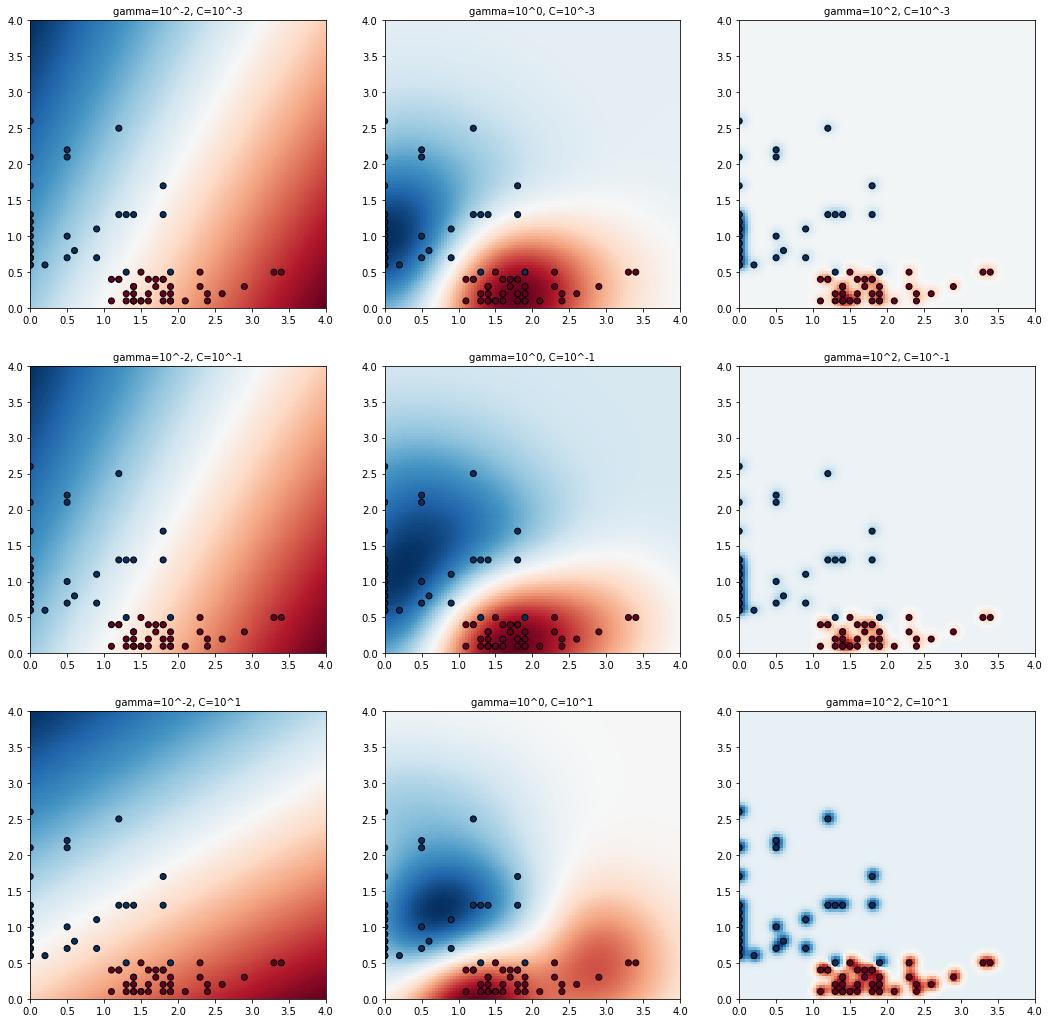

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 시각화를 하기 위해, 최적의 C와 최적의 C를 비교하기 위한 다른 C를 후보로 저장합니다.
C_candidates = [] #리스트 선언
C_candidates.append(clf.best_params_['C'] * 0.01) # 최적 C의 1/100배
C_candidates.append(clf.best_params_['C']) # 최적의 C(비용) -> 위에서 0.1이였음.
C_candidates.append(clf.best_params_['C'] * 100) # 최적 C의 100배

# 시각화를 하기 위해, 최적의 gamma와 최적의 gamma를 비교하기 위한 다른 gamma를 후보로 저장합니다.
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

X = train[['3P', 'BLK']]
Y = train['Pos'].tolist()

# 포지션에 해당하는 문자열 SG와 C를 벡터화합니다.
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)

# 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장합니다.
classifiers = []
for C in C_candidates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma) # C와 gamma값으로 SVM설정
        clf.fit(X, Y) #SVM 학습 실행
        classifiers.append((C, gamma, clf)) #C와 gamma,SVM 실행 결과를 classifiers에 저장

# 18,18 사이즈의 챠트를 구성합니다.
plt.figure(figsize=(18, 18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100)) # linespace(시작,끝,전체 점의 수)
# 위 문장 실행 후, xx = [[0, 0.04, 0.08, ... , 1, 1.04, ... , 2, ... , 3, ... , 4],
#                       [0, 0.04, 0.08, ... , 1, 1.04, ... , 2, ... , 3, ... , 4],
#                                   .....................
#                       [0, 0.04, 0.08, ... , 1, 1.04, ... , 2, ... , 3, ... , 4]]  <= 100줄
#                  yy = [[     0,      0,      0, ... ,    0],
#                       [0.04, 0.04, 0.04, ... ,0.04],
#                       [0.08, 0.08, 0.08, ... ,0.08],
#                           .....................
#                       [     4,      4,      4, ... ,    4]]   <= 100줄

# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화합니다.
for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # (예) for k, name in enumerate (['body', 'foo', 'bar']):
    #            print(k, name)
    #       ==> 실행 결과 : 0 body
    #                       1 foo
    #                       2 bar        
    # clf.decision_function : clf의 값을 사용하여 경계면을 찾아내는 함수. 경계면이면 0, 한쪽 클래스는 음수,
    #                         나머지 한쪽 클래스는 양수로 값을 출력함.
    # xx.shape : xx의 모양(여기서는 100x100)
    # Z.reshape(xx.shape) : Z를 ()의 모양(즉, 여기서는 100x100)으로 2차원 리스트로 만들어줌. 이거를 하는 이유는
    #                       decision_function의 결과가 저장된 Z는 1차원 리스트로 저장되어 있음. 이거를 
    #                       2차원 그래프로 나타내기 위해 reshape 명령을 사용해서 2차원 리스트로 만들어 주는 것임.
    
    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화해봅니다.
    plt.subplot(len(C_candidates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # 서포트 벡터와 결정경계선 그리기
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu) # xx와 yy 좌표에 대해 Z값으로 색상 그리기
    # cmap에서 지정한 색상에 따라 Z 값으로 색상을 그리는데, cmap이 Rd(Red), Bu(Blue) 순이므로 Z가 음수이면 빨간색,
    # 양수이면 파란색, 0이면 하얀색으로 색상을 그리게 됨. 그런데 이대로 그림을 그리면 색상이 반대로 표시되어 정상적으로 
    # 색상 표시를 하기 위해 Z에 마이너스를 붙인 것임.
    
    # 3점슛과 블로킹 값을 이용하여 센터와 슈팅가드 점 찍기
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k') # edgecolors: 테두리 색, 'k'는 'Black'.
    # 3P(x축)와 BLK(y축)의 좌표에 c값에 따른 색상으로 점을 찍음. cmap에서 RdBu_r는 Rd(Red), Bu(Blue) 순서를 뒤집으란 얘기임.
    # 즉, 앞쪽이 Blue, 그 다음이 Red가 됨. 그런데 c 값이 위에서 센터는 0, 슈팅가드는 1로 지정되어 있으므로,
    # 결국 센터는 파란색 점으로, 슈팅가드는 빨간색 점으로 찍히게 됨.


#모델 테스트

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# 테스트에 사용될 특징을 지정합니다
X_test = test[['3P', 'BLK']]

# 특징으로 예측할 값 (농구선수 포지션)을 지정합니다
y_test = test[['Pos']] # y_test는 출력 레이블임 (주의!! 1차원 리스트임)

# 최적의 파라미터로 완성된 SVM에 테스트 데이터를 주입하여, 실제값과 예측값을 얻습니다.
y_pred = clf.predict(X_test)  # 테스트 데이터(X_test)에 대해 SVM 예측 실행

# 정답 (레이블)과 예측값을 비교하여 정밀도, 재현율, F1 점수 출력
print(classification_report(y_test, y_pred))
print() # 빈 줄 추가
print("accuracy : "+ str(accuracy_score(y_test, y_pred)) )


              precision    recall  f1-score   support

           C       0.67      0.86      0.75         7
          SG       0.91      0.77      0.83        13

    accuracy                           0.80        20
   macro avg       0.79      0.81      0.79        20
weighted avg       0.82      0.80      0.80        20


accuracy : 0.8


In [ ]:
# import 추가하기
import pandas as pd

# 실제값(ground truth)과 예측값(prediction)이 어느 정도 일치하는 눈으로 직접 비교해봅니다
comparison = pd.DataFrame({'실제값':y_test.values.ravel(), '예측값':y_pred}) 
comparison

,실제값,예측값
0,SG,C
1,SG,SG
2,SG,SG
3,C,C
4,SG,SG
5,SG,SG
6,SG,SG
7,SG,C
8,C,C
9,C,C


In [ ]:

a = [[3, 0.2],[1,0.8]]
y = clf.predict(a)
print(y)

['SG' 'C']
